In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/light-gbm/lgb_regression.txt


In [2]:
import gc

In [3]:
# Reduce memory size func 

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
def prep_data(df):
    #  expanded on over time
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.rename(columns = {"timestamp":"date"},inplace= True)
    df["month"] = np.uint8(df["date"].dt.month)
    df["week"] =df["date"].dt.weekofyear
    df["weekday"] = np.uint8(df["date"].dt.weekday)
    df["day"] = np.uint8(df["date"].dt.day)
    df["hour"] = np.uint8(df["date"].dt.hour)
    df["weekend"] = [1 if x in [5,6] else 0 for x in df.day]
    
    df['part_of_day'] = (df['date'].dt.hour % 24 + 4) // 4
    df['part_of_day'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)
   
    # Encode meter types
    df['meter'] = pd.Categorical(df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
    
    df['log_square_feet'] = np.log(df['square_feet'])
    
    df['year_built'] = df['year_built']-1900
 
    df.floor_count.fillna(0,inplace = True)  
    columns = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
'sea_level_pressure', 'wind_direction','wind_speed'] 
    for col in columns:
        imputation = df.groupby(['site_id','month','part_of_day'])[col].transform('mean')
        df[col].fillna(imputation,inplace = True)
    df = reduce_mem_usage(df)
    gc.collect()
    #remove outliers train data
   
    
    # remove redundant columns
    for col in df.columns:
        if col in ['date', 'row_id']:
            del df[col]
    if 'meter_reading' in df.columns:
        df['meter_reading'] = np.log1p(df['meter_reading']) # comp metric uses log errors

    return df
    
    print('Data is ready')

In [14]:
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
build = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
train = train.merge(build, on='building_id', how='left')
alltrain = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
del train, weather_train,build
gc.collect()
print('Data is imported')

Data is imported


In [15]:
alltrain =prep_data(alltrain)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Memory usage after optimization is: 1349.57 MB
Decreased by 57.6%


In [ ]:
 #remove outliers train data
alltrain.drop(alltrain[(alltrain.site_id==0) & ( alltrain.date < "2016-05-20 00:00:00") & 
                       (alltrain.meter =="electricity")].index,inplace= True )
    
alltrain.drop(alltrain[alltrain.building_id == 1099].index,inplace = True)
    

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
categorical_columns = ["building_id","site_id","meter","month"]

In [7]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
alltrain.part_of_day =le.fit_transform(alltrain["part_of_day"])
alltrain.primary_use =le.fit_transform(alltrain["primary_use"])

In [19]:
alltrain["building_id"] = alltrain["building_id"].astype('category')
alltrain["site_id"] = alltrain["site_id"].astype('category')
alltrain["meter"] = alltrain["meter"].astype('category')
alltrain["month"] = alltrain["month"].astype('category')


In [31]:
x = alltrain.drop(["square_feet","year_built","meter_reading",'precip_depth_1_hr',
'sea_level_pressure', 'wind_direction','wind_speed'],axis =1)
y = alltrain["meter_reading"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [34]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)

lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}


gbm = lgb.train(params,
                train_set=lgb_train,
               
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=150,categorical_feature = categorical_columns)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

[1]	valid_0's rmse: 2.04084
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 2.00237
[3]	valid_0's rmse: 1.96742
[4]	valid_0's rmse: 1.92783
[5]	valid_0's rmse: 1.8896
[6]	valid_0's rmse: 1.84805
[7]	valid_0's rmse: 1.81961
[8]	valid_0's rmse: 1.78263
[9]	valid_0's rmse: 1.74819
[10]	valid_0's rmse: 1.71647
[11]	valid_0's rmse: 1.6905
[12]	valid_0's rmse: 1.66729
[13]	valid_0's rmse: 1.64317
[14]	valid_0's rmse: 1.62347
[15]	valid_0's rmse: 1.60403
[16]	valid_0's rmse: 1.58615
[17]	valid_0's rmse: 1.56774
[18]	valid_0's rmse: 1.55007
[19]	valid_0's rmse: 1.53072
[20]	valid_0's rmse: 1.51601
[21]	valid_0's rmse: 1.50258
[22]	valid_0's rmse: 1.48505
[23]	valid_0's rmse: 1.47325
[24]	valid_0's rmse: 1.46112
[25]	valid_0's rmse: 1.44567
[26]	valid_0's rmse: 1.43612
[27]	valid_0's rmse: 1.42191
[28]	valid_0's rmse: 1.40477
[29]	valid_0's rmse: 1.39792
[30]	valid_0's rmse: 1.38404
[31]	valid_0's rmse: 1.37501
[32]	valid_0's rmse: 1.36551
[33]	valid_0's rmse: 

[272]	valid_0's rmse: 0.873872
[273]	valid_0's rmse: 0.873478
[274]	valid_0's rmse: 0.873295
[275]	valid_0's rmse: 0.873016
[276]	valid_0's rmse: 0.872745
[277]	valid_0's rmse: 0.872224
[278]	valid_0's rmse: 0.871847
[279]	valid_0's rmse: 0.8712
[280]	valid_0's rmse: 0.871074
[281]	valid_0's rmse: 0.870891
[282]	valid_0's rmse: 0.870537
[283]	valid_0's rmse: 0.870066
[284]	valid_0's rmse: 0.869804
[285]	valid_0's rmse: 0.869174
[286]	valid_0's rmse: 0.86793
[287]	valid_0's rmse: 0.867828
[288]	valid_0's rmse: 0.867106
[289]	valid_0's rmse: 0.866672
[290]	valid_0's rmse: 0.866496
[291]	valid_0's rmse: 0.865597
[292]	valid_0's rmse: 0.86534
[293]	valid_0's rmse: 0.865167
[294]	valid_0's rmse: 0.864925
[295]	valid_0's rmse: 0.864555
[296]	valid_0's rmse: 0.863832
[297]	valid_0's rmse: 0.863195
[298]	valid_0's rmse: 0.862883
[299]	valid_0's rmse: 0.862485
[300]	valid_0's rmse: 0.861917
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.861917
The rmse of prediction is:

In [35]:
gbm.save_model('lgb2_regression.txt', num_iteration=gbm.best_iteration) 

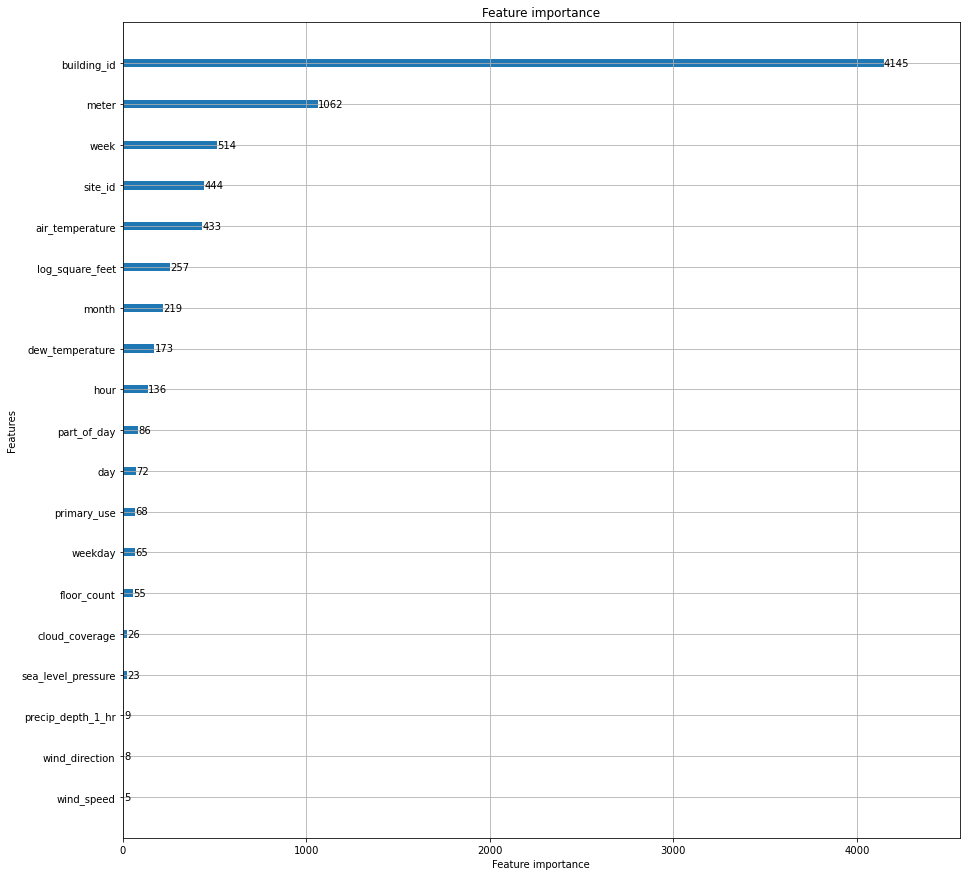

In [7]:
ax = lgb.plot_importance(gbm, figsize=(15,15))


In [5]:
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
build = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
test =test.merge(build, on='building_id', how='left')
alltest= test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del test, weather_test,build
gc.collect()
print('Data is imported')

Data is imported


In [6]:
alltest = prep_data(alltest)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Memory usage after optimization is: 2783.62 MB
Decreased by 57.6%


In [8]:
alltest["building_id"] = alltest["building_id"].astype('category')
alltest["site_id"] = alltest["site_id"].astype('category')
alltest["month"] = alltest["month"].astype('category')
alltest["meter"] = alltest["meter"].astype('category')

In [9]:
le = LabelEncoder()
alltest.part_of_day =le.fit_transform(alltest["part_of_day"])
alltest.primary_use =le.fit_transform(alltest["primary_use"])

In [10]:
alltest.drop(["year_built","square_feet",'precip_depth_1_hr',
'sea_level_pressure', 'wind_direction','wind_speed'],axis =1,inplace = True)

In [12]:
alltest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
 #   Column           Dtype   
---  ------           -----   
 0   building_id      category
 1   meter            category
 2   site_id          category
 3   primary_use      int64   
 4   floor_count      float16 
 5   air_temperature  float16 
 6   cloud_coverage   float16 
 7   dew_temperature  float16 
 8   month            category
 9   week             int8    
 10  weekday          uint8   
 11  day              uint8   
 12  hour             uint8   
 13  weekend          int8    
 14  part_of_day      int64   
 15  log_square_feet  float16 
dtypes: category(4), float16(5), int64(2), int8(2), uint8(3)
memory usage: 1.7 GB


In [13]:
import lightgbm as lgb

In [15]:
gbm = lgb.Booster(model_file='../input/lgb2-reg/lgb2_regression.txt')

In [16]:
y_result = gbm.predict(alltest, num_iteration=gbm.best_iteration)


In [17]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = np.exp(y_result)
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission2.csv', index=False)
